In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (35,20)

import seaborn as sns
import datetime

dir_dataset = "C:/Users/0stix/Datasets/"

name_dataset = 'TPS_jan_2022'

df_train = pd.read_csv(dir_dataset+name_dataset+'/train.csv')
df_test = pd.read_csv(dir_dataset+name_dataset+'/test.csv')
df_sub = pd.read_csv(dir_dataset+name_dataset+'/sample_submission.csv')
len_train = len(df_train)
target='num_sold'

df_all = pd.concat([df_train,df_test],axis=0)

## 데이터 유형 파악
- 데이터 개략: 국가, 유통업체, 제품 별 2015-2018년의 하루 단위 판매량
- 목표: 각 항목 별 2019년의 일별 판매량 예측

In [2]:
df_all.head(36)

,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329.0
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520.0
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146.0
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572.0
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911.0
5,5,2015-01-01,Finland,KaggleRama,Kaggle Sticker,283.0
6,6,2015-01-01,Norway,KaggleMart,Kaggle Mug,526.0
7,7,2015-01-01,Norway,KaggleMart,Kaggle Hat,906.0
8,8,2015-01-01,Norway,KaggleMart,Kaggle Sticker,250.0
9,9,2015-01-01,Norway,KaggleRama,Kaggle Mug,1005.0


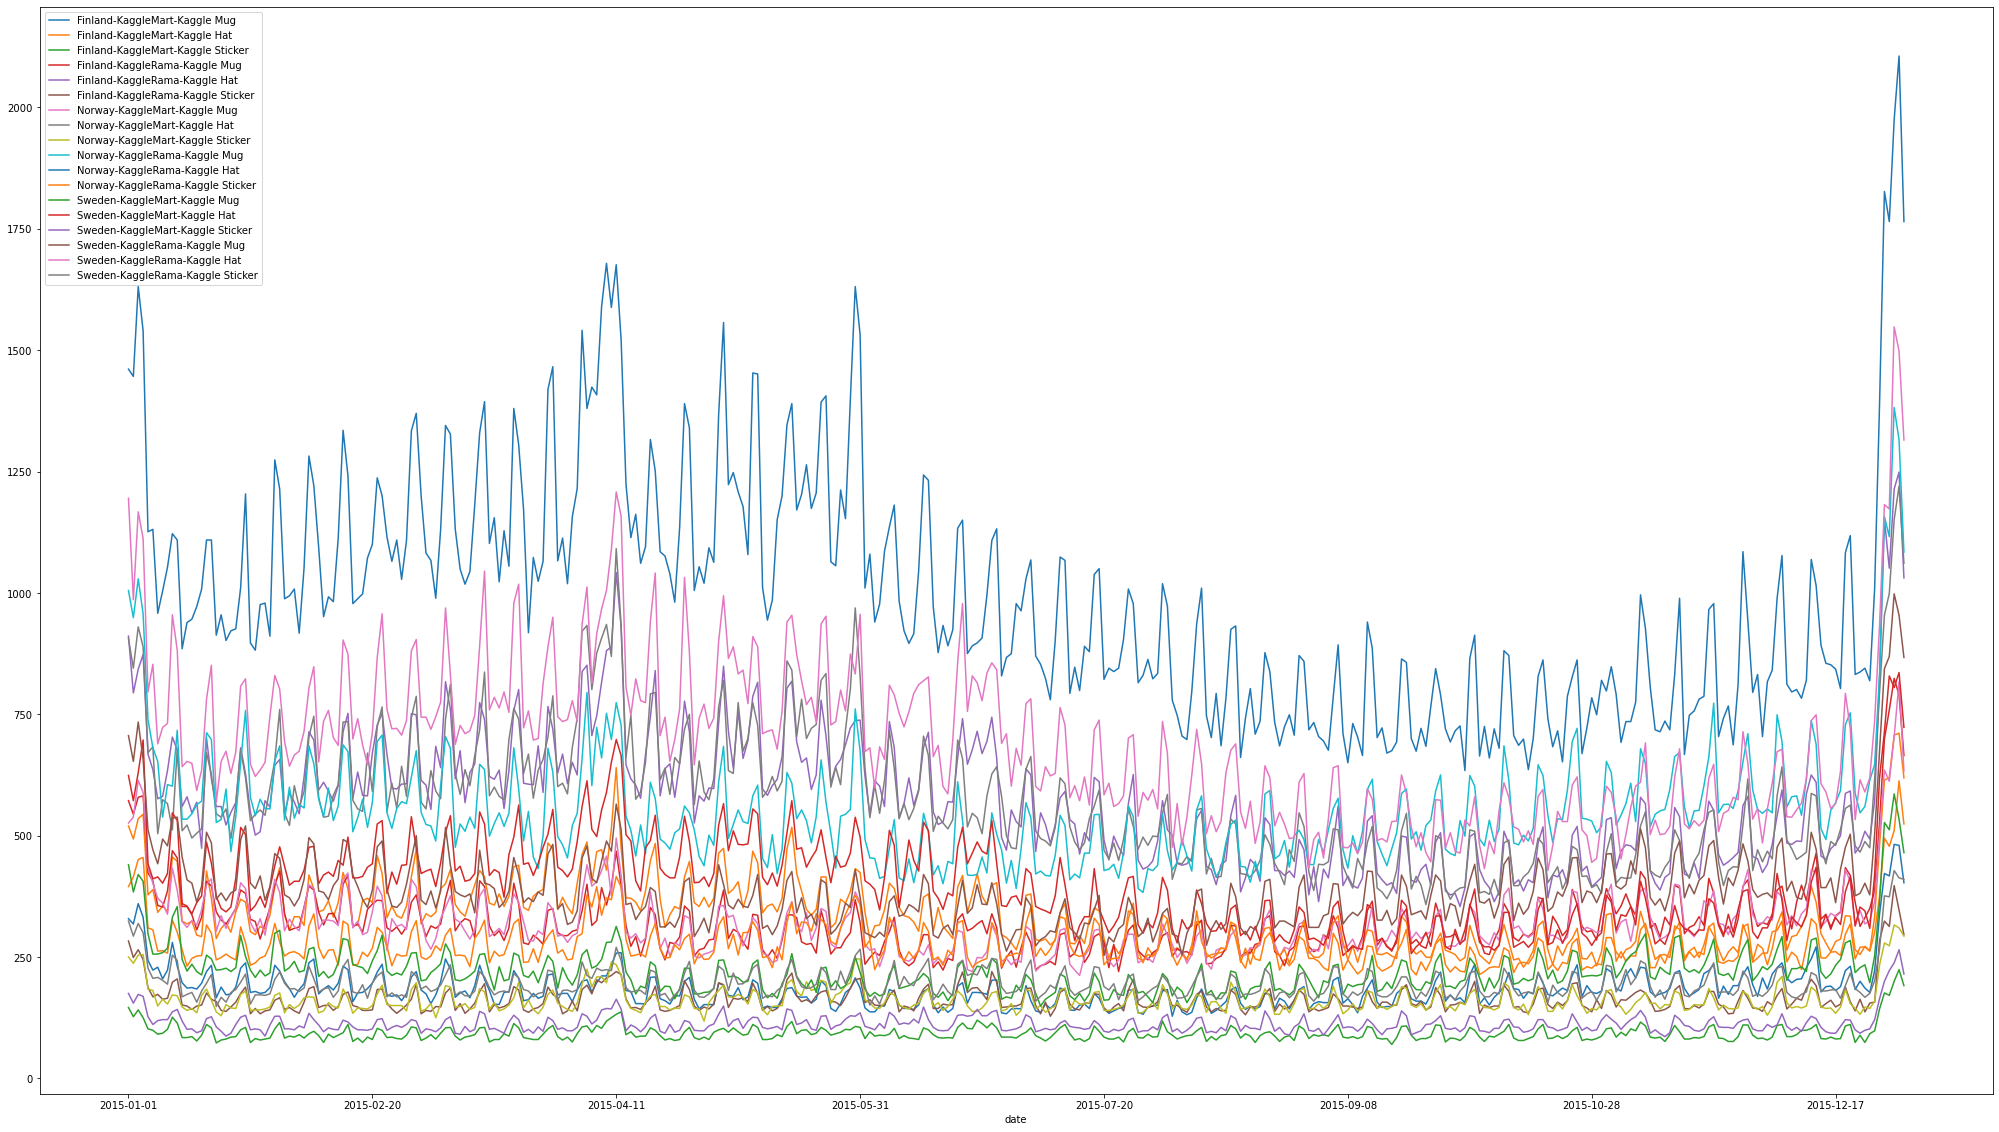

In [3]:
from itertools import product

df_t = pd.DataFrame()

dct_ = {
    'country':['Finland','Norway','Sweden'],
    'store':['KaggleMart','KaggleRama'],
    'product':['Kaggle Mug','Kaggle Hat','Kaggle Sticker']
}


for country, store, product in product(dct_['country'], dct_['store'], dct_['product']):
    df_t['-'.join([country, store, product])] = df_train[
        (df_train['country']==country) & 
        (df_train['store']==store) & 
        (df_train['product']==product)].set_index('date')['num_sold'].astype(float)
    

df_t['2015-01-01':'2015-12-31'].plot()
plt.show()

## 기본 처리

In [4]:
# SMAPE 정의
def smape(t, p):
    return 100 / len(t) * np.sum(np.abs(p - t) / (np.abs(t) + np.abs(p)))

In [38]:
from sklearn.preprocessing import OneHotEncoder

df_v0 = pd.DataFrame()

for attrib in ['country', 'store', 'product']:
    df_v0[attrib] = df_all[attrib].astype('category').cat.codes

df_v0['datetime'] = pd.to_datetime(df_all['date'])
# df_v0 = pd.concat([df_v0, pd.get_dummies(df_v0['datetime'].dt.year.astype('category').cat.codes, prefix='year')], axis=1)
# df_v0 = pd.concat([df_v0, pd.get_dummies(df_v0['datetime'].dt.month.astype('category').cat.codes, prefix='month')], axis=1)
df_v0 = pd.concat([df_v0, df_v0['datetime'].dt.dayofweek], axis=1)

# df_v0 = pd.concat([df_v0, pd.get_dummies(df_v0['datetime'].dt.day.astype('category').cat.codes, prefix='day')], axis=1)
# df_v0.drop('datetime', axis=1, inplace=True)

df_v0[target] = df_all[target].copy()
df_train_v0 = df_v0[:len_train]
df_test_v0 = df_v0[len_train:]

In [39]:
df_v0[df_v0.country==0].head(30)

,country,store,product,datetime,datetime,num_sold
0,0,0,1,2015-01-01,3,329.0
1,0,0,0,2015-01-01,3,520.0
2,0,0,2,2015-01-01,3,146.0
3,0,1,1,2015-01-01,3,572.0
4,0,1,0,2015-01-01,3,911.0
5,0,1,2,2015-01-01,3,283.0
18,0,0,1,2015-01-02,4,318.0
19,0,0,0,2015-01-02,4,493.0
20,0,0,2,2015-01-02,4,127.0
21,0,1,1,2015-01-02,4,544.0


In [6]:
from sklearn.model_selection import train_test_split
X_, y_ = df_v0.drop([target], axis=1).values, df_v0[[target]].values
X_train, test_, y_train = X_[:len_train], X_[len_train:], y_[:len_train]
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [7]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_t, y_t.flatten())
y_p = rf_reg.predict(X_v)
smape_ = smape(y_v.flatten(), y_p)
print('smape: ', smape_)

smape:  5.833334698853515


## 시계열분석 시도
- 삽질을 오래 했으나 별로 얻은 것이 없음.
- 옆반은 이를 적절히 활용한 것으로 보임, 몇가지 트릭만 더 썼어도 우리가 졌을 것.

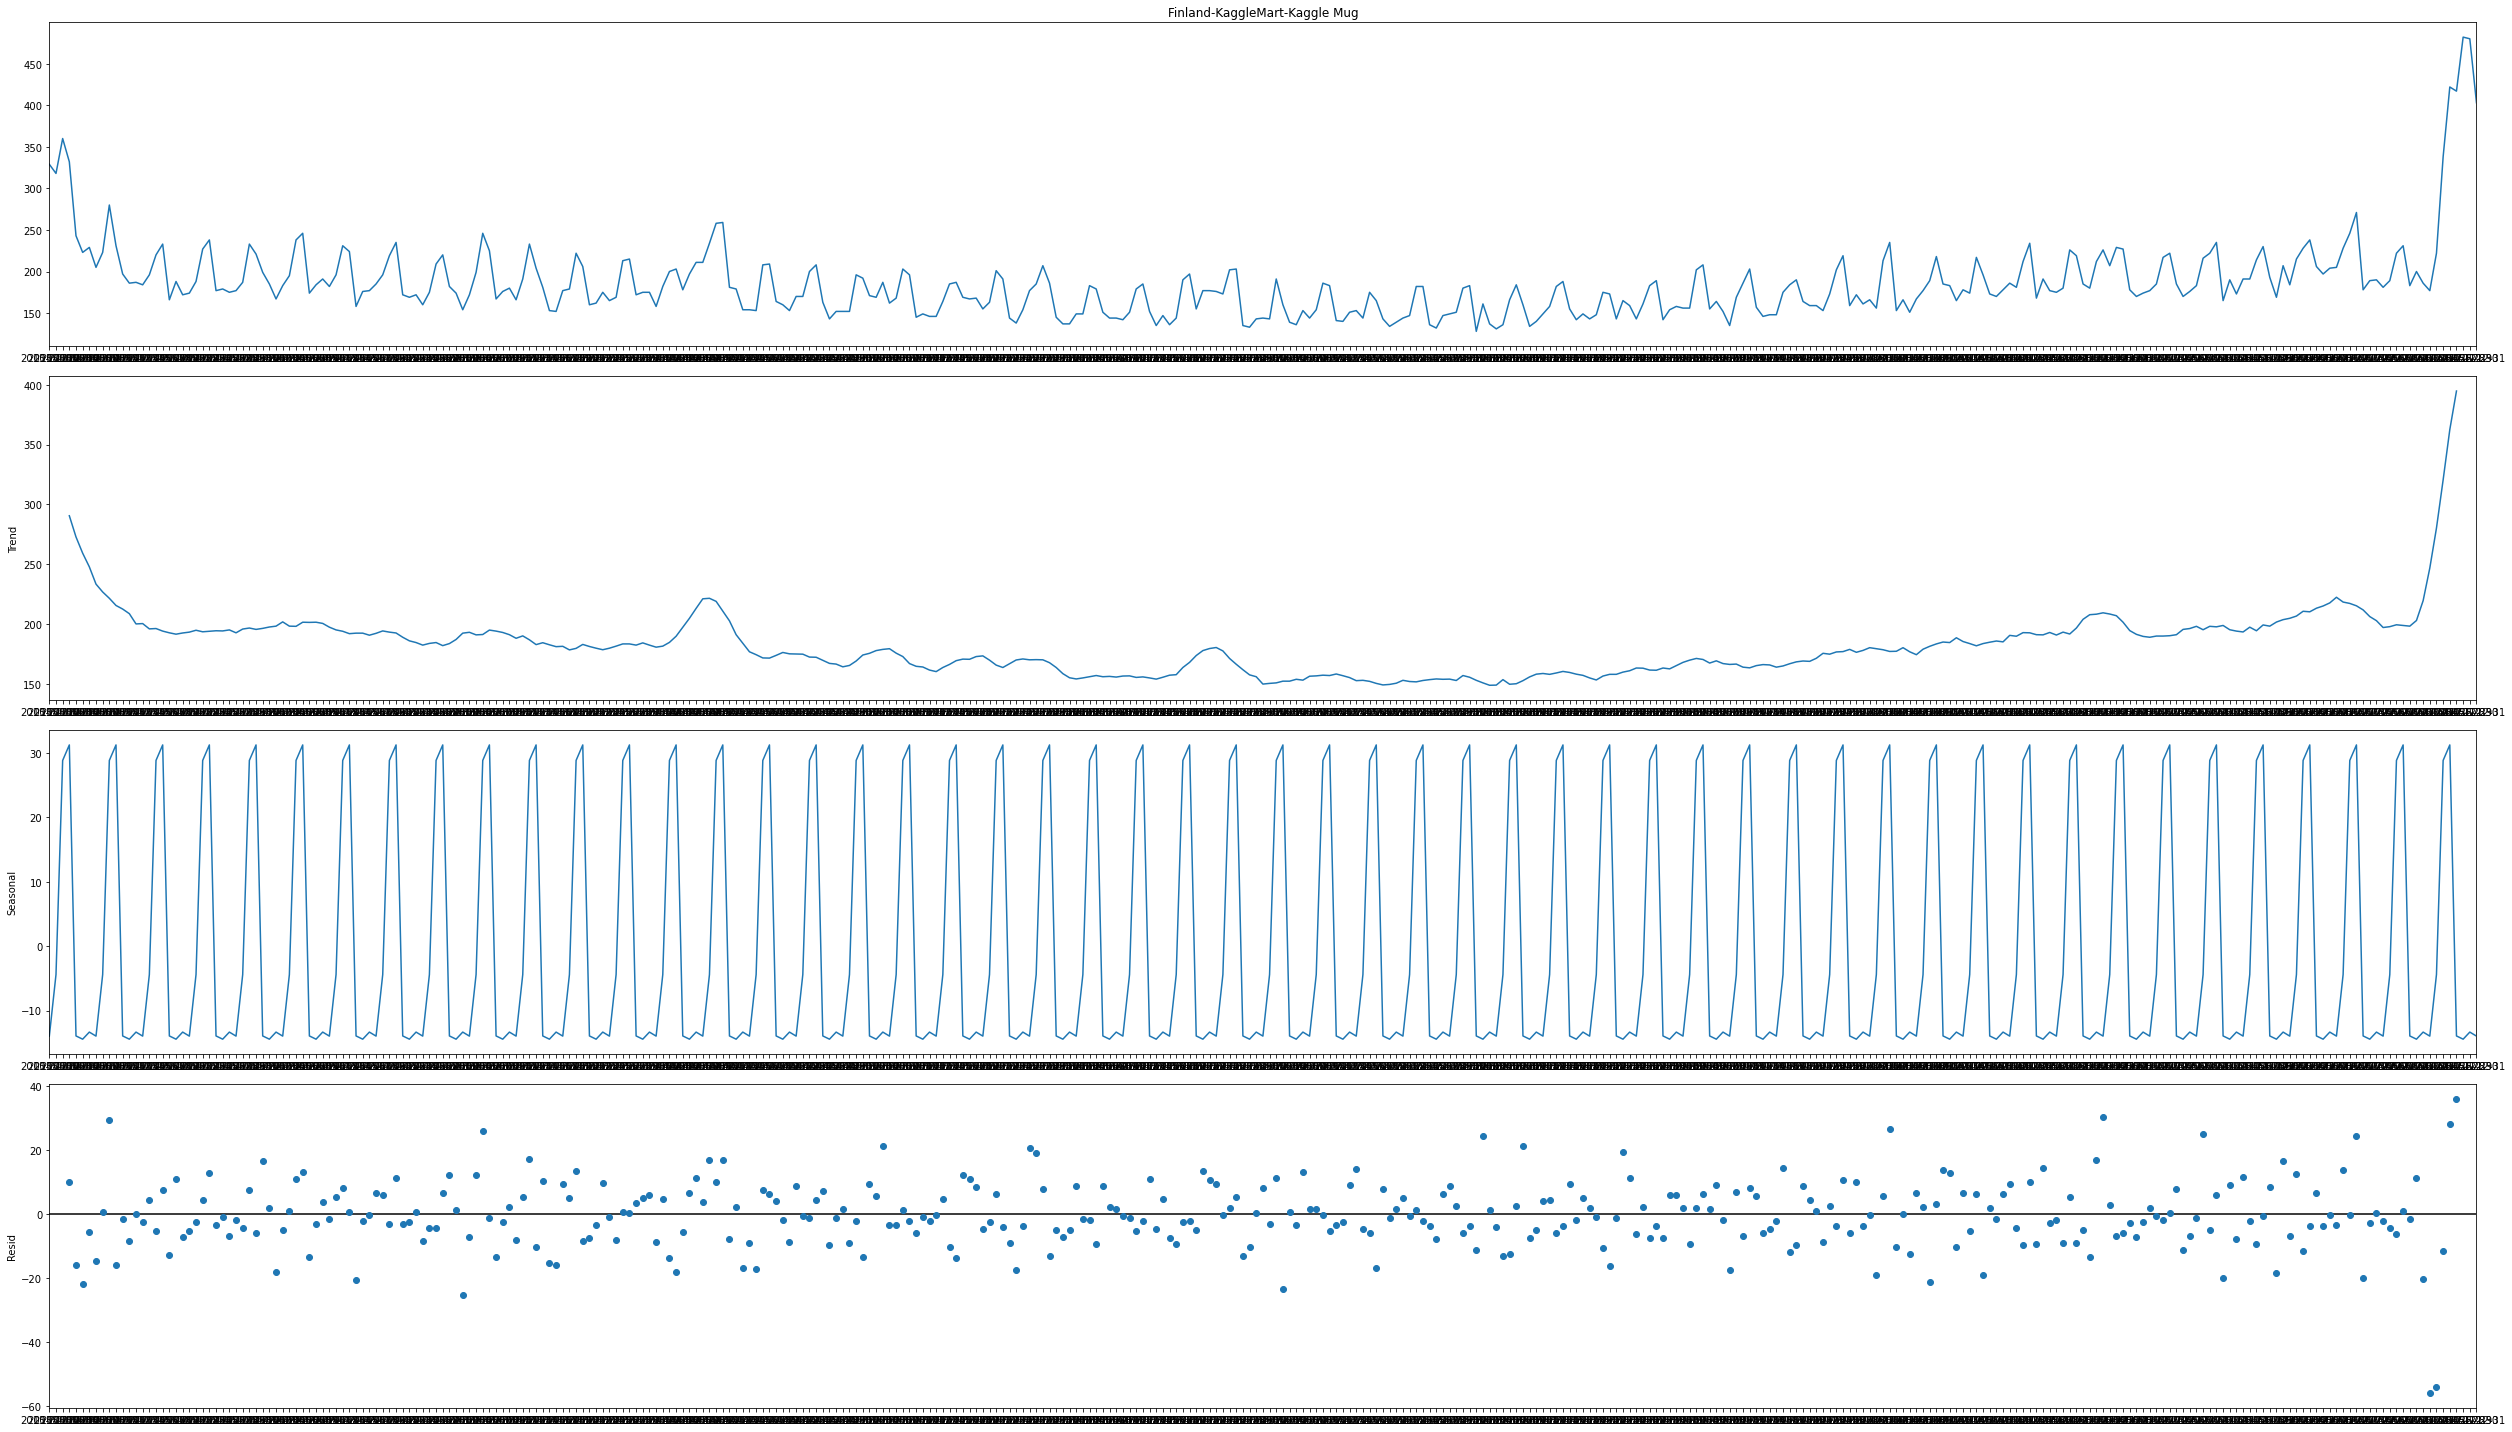

In [41]:
import statsmodels.tsa.api as tsa
model_series = tsa.seasonal_decompose(df_t['Finland-KaggleMart-Kaggle Mug']['2015-01-01':'2015-12-31'], period=7, model='additive')

fig = model_series.plot()
plt.show()

## 다른 모델 시도

In [9]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

xgb_reg = RandomForestRegressor()
xgb_reg.fit(X_t, y_t.flatten())
y_p = xgb_reg.predict(X_v)
smape_ = smape(y_v.flatten(), y_p)
print('smape: ', smape_)

lgbm_reg = RandomForestRegressor()
lgbm_reg.fit(X_t, y_t.flatten())
y_p = lgbm_reg.predict(X_v)
smape_ = smape(y_v.flatten(), y_p)
print('smape: ', smape_)

smape:  5.849705023891118
smape:  5.855398911729595


## 휴일 도입 및 항목 추가/제거
- 휴일이 지정되는 방식이 `~번째 달의 ~번째 ~요일` 방식으로 정해지는 경우가 있어 이전 방식 그대로 `~월,~일`로 나누는 것에 한계가 있었음.
- day를 제거하고 week을 추가, holidays 모듈 도입해서 실제 공휴일만 체크
- year항목 제거: 예측 데이터는 전부 2019년이므로, 2015-2018년의 것만 갖고 있는 test 데이터는 도움이 안됨.

In [10]:
from sklearn.preprocessing import OneHotEncoder
from holidays import Finland, Norway, Sweden

df_v0 = pd.DataFrame()

for attrib in ['country', 'store', 'product']:
    df_v0[attrib] = df_all[attrib].astype('category').cat.codes

df_v0['datetime'] = pd.to_datetime(df_all['date'])

# df_v0 = pd.concat([df_v0, pd.get_dummies(df_v0['datetime'].dt.year.astype('category').cat.codes, prefix='year')], axis=1)
df_v0 = pd.concat([df_v0, pd.get_dummies(df_v0['datetime'].dt.month.astype('category').cat.codes, prefix='month')], axis=1)
df_v0 = pd.concat([df_v0, pd.get_dummies(df_v0['datetime'].dt.isocalendar().week.astype('category').cat.codes, prefix='week')], axis=1)
# df_v0 = pd.concat([df_v0, pd.get_dummies(df_v0['datetime'].dt.day.astype('category').cat.codes, prefix='day')], axis=1)
df_v0 = pd.concat([df_v0, pd.get_dummies(df_v0['datetime'].dt.dayofweek.astype('category').cat.codes, prefix='dow')], axis=1)

df_v0['holidays'] = 0

lst_holidays = []
lst_holidays.append(Finland())
lst_holidays.append(Norway())
lst_holidays.append(Sweden())

df_v0['holidays'] = df_v0.apply(lambda row: 1 if row['datetime'] in lst_holidays[row['country']] else 0, axis=1)
df_v0.drop('datetime', axis=1, inplace=True)

df_v0[target] = df_all[target].copy()
df_train_v0 = df_v0[:len_train]
df_test_v0 = df_v0[len_train:]

In [11]:
X_, y_ = df_v0.drop([target], axis=1).values, df_v0[[target]].values
X_train, test_, y_train = X_[:len_train], X_[len_train:], y_[:len_train]
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [20]:
lgbm_reg = LGBMRegressor()
lgbm_reg.fit(X_t, y_t.flatten())
y_p = lgbm_reg.predict(X_v)
smape_ = smape(y_v.flatten(), y_p)
print('smape: ', smape_)

smape:  4.128205710873964


In [21]:
df_sub[target] = lgbm_reg.predict(test_)
now = datetime.datetime.now()
str_datetime = now.strftime("%y%m%d_%H%M%S")
df_sub.to_csv(dir_dataset+'submission-'+name_dataset+'-'+str_datetime+'.csv', index = 0)

## 마지막 꼼수: GDP
- 각 국의 GDP 변동은 상품 판매량에도 영향을 줄 것이란 가설에 바탕
- 핀란드, 노르웨이, 스웨덴 각 국의 2015-2018년의 GDP 평균과 2019년의 GDP의 배율을 구한 후 계산
- 논란의 여지가 있을 수 있는 방법

In [22]:
df_sub[target] = lgbm_reg.predict(test_)

lst_gdp = [1.07,1.013,1.003]
df_sub['num_sold'] = df_sub.apply(lambda row: row['num_sold'] * lst_gdp[((int(row['row_id'])%18))//6], axis=1)

now = datetime.datetime.now()
str_datetime = now.strftime("%y%m%d_%H%M%S")
df_sub.to_csv(dir_dataset+'submission-'+name_dataset+'-'+str_datetime+'.csv', index = 0)